# UniverSeg

- From the following paper: https://universeg.csail.mit.edu/
- From the git repo: https://github.com/JJGO/UniverSeg
- Form the example google colab: https://colab.research.google.com/drive/1TiNAgCehFdyHMJsS90V9ygUw0rLXdW0r?usp=sharing

Quoted from the tutorial, helpful text for setting up the context;

"""Given a new segmentation task (e.g. new biomedical domain, new image type, new region of interest, etc), most existing strategies involve training or fine-tuning a segmentation model (often a UNet-like CNN) that takes as input an image $x$ and outputs the segmentation map $y$.

This process works well in machine-learning labs, but is challenging in many applied settings, such as for scientists or clinical researchers who drive important scientific questions, but often lack the machine-learning expertiese and computational resources necessary.

UniverSeg enables users to tackle a new segmentation task without the need to train or fine-tune a model, removing the ML experience requirements and computational burden. The key idea is to have a *single* global model which adapts to a new segmentation task at inference. Given a new segmentation task, defined by a few example image-segmentation pairs $\mathcal{T} = \{x_n, y_n\}$, UniverSeg segments a new image $x$ by taking as input both $x$ and the task examples $\mathcal{T}$ and outputs the segmentation map $f(x, \mathcal{T}) = y$."""

## Setup

In [1]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)


Device: cuda


In [9]:
import os 
import subprocess

def setup_data_vars(mine = True, overwrite = True):
    """
    From within any directory related to radiotherapy with backtrack into the data folder
    and execute the data_vars script. The assumption is that the datavars script will
    output the list of environment variables that need to be set. This function will set
    the environment variables for the current session.

    For the mean while, my model hasn't completely finished training, therefore, to get
    this task done, I will use Ben's pretrained nnUNet and then once mine has finished
    training I will use my own. For the mean while, this means that we can choose between
    using Ben's pretrained model or my own.
    """

    # If the environment variables are not set, assume that either a custom one has been
    # provided or resetting them again is a redundant task
    if os.environ.get('nnUNet_raw') is None or overwrite is True:
        # run the script in the data folder for specifying the environment variables
        if mine:
            cwd = os.getcwd().split('/')
            data_dir = os.path.join('/'.join(cwd[:cwd.index('radiotherapy') + 1]), 'data')

            # Assuming the data_vars.sh script echoes the environment variables
            script = os.path.join(data_dir, 'data_vars.sh')
            output = subprocess.run([script], capture_output=True)
            
            assert len(output.stdout) != 0, f"Please check {script} and make sure it echoes \
    the environment variables."

            output = output.stdout.decode('utf-8')
        else:
            data_dir = '/vol/biomedic3/bglocker/nnUNet'

            # Assuming this script won't change, it contains hard coded exports
            script = os.path.join(data_dir, 'exports')

            with open(script, 'r') as file:
                output = file.read()
        
        for line in output.split('\n'):
            if line != '':
                if mine:
                    line = line.split(': ')
                    os.environ[line[0]] = line[1]
                else:
                    line = line.split('=')
                    os.environ[line[0].split(' ')[1]] = line[1]

    assert os.environ.get('nnUNet_raw') is not None, "Environemnt variables not set. \
Please run the data_vars.sh script in the data folder."

setup_data_vars()

## Preprocessing

In [3]:
from tqdm import tqdm
import SimpleITK as sitk
import numpy as np
import torchio as tio

def universeg_preprocess(path_to_images: str, overwrite = True, label = False):
    """Given a input path to images, preprocess the images according to the specification
    supplied by the paper. That is, we resize the input images to be 128x128 WxH
    dimensions and normalize the CT images to be within the range of 0 to 1. The images
    are then saved to a new directory with a sensible name. Files will be named after the
    input, therefore, if there are alraedy files in this directory, we will check that
    there is a match between a filename and the input image in order to skip.

    From the paper at: https://arxiv.org/pdf/2006.13256.pdf
    "For CT images, we clip intensity values to the range [-500, 1000]. We min-max
    normalize all resulting volumes to [0, 1] and resize them to (128 x 128 x 128). From
    any 3D volumes, we extract two different kinds of slices: mid-slices and max-slices"

    Args:
        path_to_images (str): A path to the directory containing the images that need to
        be preprocessed. The output directory will be saved in a sensible location
        derrived from `os.environ.get('nnUNet_raw)`
        
        normalize (bool): A flag to indicate whether the input pixels values should be
        normalized to the 0 to 1 range. 

        overwrite (bool): A flag to indicate whether the output directory should be
        overwritten.
    """

    # Check that the input directory exists
    assert os.path.exists(path_to_images), f"Path to images: {path_to_images} does not exist."
    assert os.environ.get('nnUNet_raw') is not None, "Environment variables not set. \
Please run the data_vars.sh script in the data folder."

    def resize_image(original_CT):
        # Data Augmentation with SimpleITK:
        # https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/70_Data_Augmentation.ipynb
        # https://stackoverflow.com/questions/48065117/simpleitk-resize-images

        # The spatial definition of the images we want to use in a deep learning framework (smaller than the original).
        new_size = [128] * 3
        reference_image = sitk.Image(new_size, original_CT.GetPixelIDValue())
        reference_image.SetOrigin(original_CT.GetOrigin())
        reference_image.SetDirection(original_CT.GetDirection())
        reference_image.SetSpacing(
            [
                sz * spc / nsz
                for nsz, sz, spc in zip(new_size, original_CT.GetSize(), original_CT.GetSpacing())
            ]
        )

        resampled_image = sitk.Resample(sitk.SmoothingRecursiveGaussian(original_CT, 2.0), reference_image)
        # # Resample without any smoothing.
        # sitk.Show(sitk.Resample(original_CT, reference_image), "resampled without smoothing")

        return resampled_image

    def normalize_image(image):
        # https://www.imaios.com/en/resources/blog/ct-images-normalization-zero-centering-and-standardization
        # https://torchio.readthedocs.io/transforms/preprocessing.html#rescaleintensity
        # https://torchio.readthedocs.io/transforms/preprocessing.html#clamp

        # clip the values to be between -500 and 1000
        clip_transform = tio.Clamp(out_min = -500, out_max = 1000)
        # Create normalization transform
        normalization_transform = tio.transforms.RescaleIntensity(out_min_max = (0, 1), in_min_max = (-500, 1000)) #percentiles = (0.5, 99.5))

        tio_image = tio.ScalarImage.from_sitk(image)

        # Apply the transforms
        clipped_image = clip_transform(tio_image)
        normalized_image = normalization_transform(clipped_image).as_sitk()

        min = np.min(sitk.GetArrayFromImage(normalized_image))
        max = np.max(sitk.GetArrayFromImage(normalized_image))
        assert (min, max) == (0, 1), f"Got ({min, max}) expected (0, 1) for {input_file}"       

        return normalized_image


    # Get the output directory
    class_name = path_to_images.split('/')[-2]
    image_type = path_to_images.split('/')[-1]
    output_dir = os.path.join(os.environ.get('nnUNet_raw')[:-len('nnUNet_raw')-1], 'UniverSegPreprocessed', class_name, image_type)
    os.makedirs(output_dir, exist_ok=True)

    # Arrange files to pre-process
    input_files = sorted([file for file in os.listdir(path_to_images) if file.endswith('.nii.gz')])
    output_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.nii.gz')])

    prefix = 'universeg_'

    to_process = sorted(set(input_files)- set([file[len(prefix):] for file in output_files])) if not overwrite else input_files

    for file in tqdm(to_process):
        input_file = os.path.join(path_to_images, file)
        output_file = os.path.join(output_dir, prefix + file)

        # Load data
        data = sitk.ReadImage(input_file)
        # Resize data
        data = resize_image(data)
        # Normalize data
        if label:
            # set to binary mask if a pixel is greater than 0 then it is 1
            data = sitk.BinaryThreshold(data, lowerThreshold=0.03, upperThreshold=np.inf, insideValue=1, outsideValue=0)
        else:
            data = normalize_image(data)
        
        min = np.min(sitk.GetArrayFromImage(data))
        max = np.max(sitk.GetArrayFromImage(data))

        assert (min, max) == (0, 1), f"Got ({min, max}) expected (0, 1) for {input_file}"
        assert data.GetSize() == (128, 128, 128), f"Size is {data.GetSize()} expected (128, 128, 128) for {input_file}"

        # Save data
        sitk.WriteImage(data, output_file)      

    return output_dir

## Viewing

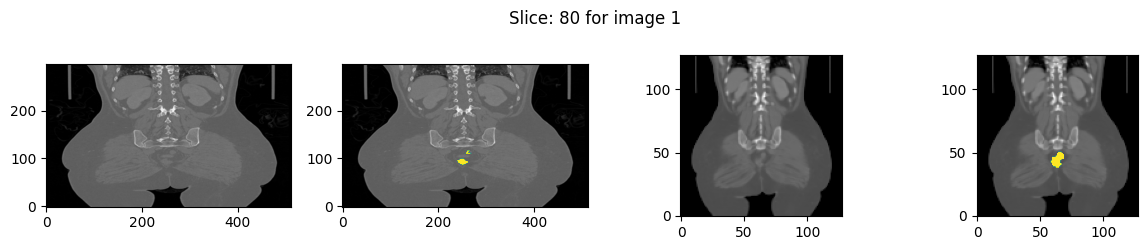

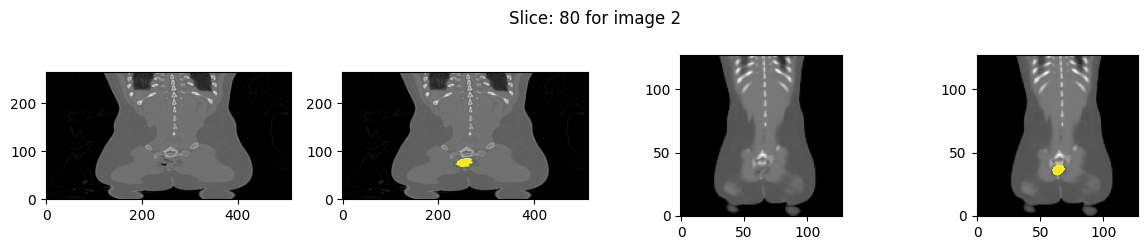

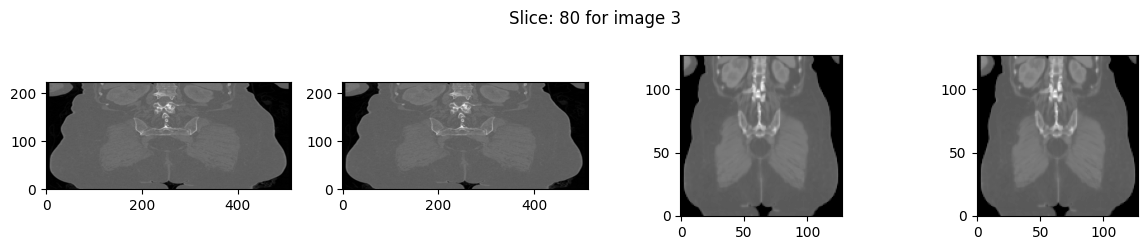

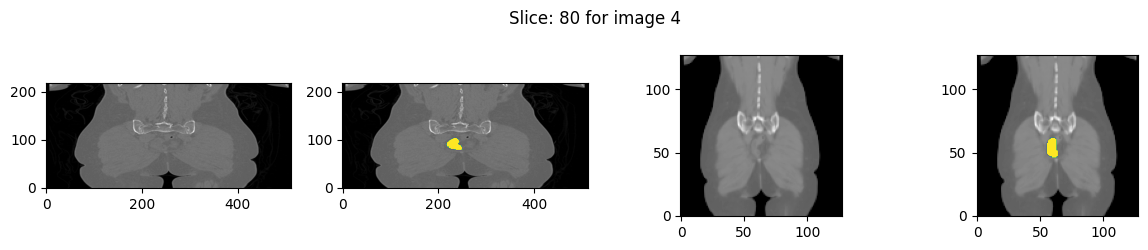

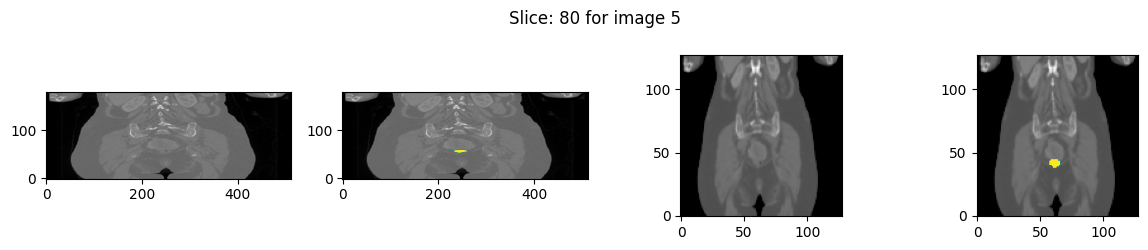

In [10]:
import matplotlib.pyplot as plt

def plot_before_and_after_preprocessing_for_Universeg(slice, slice2, num, class_id):
    # Define the dimensions of the plot
    ncols = 4
    nrows = 1

    img1, gt1, img2, gt2, = (
        '/'.join([os.environ.get("nnUNet_raw"), class_id, os.environ.get("data_trainingImages"), 'zzAMLART_{:03d}_0000.nii.gz'.format(num)]),
        '/'.join([os.environ.get("nnUNet_raw"), class_id, os.environ.get("data_trainingLabels"), 'zzAMLART_{:03d}.nii.gz'.format(num)]),
        '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/imagesTr/universeg_zzAMLART_{:03d}_0000.nii.gz'.format(class_id, num),
        '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/labelsTr/universeg_zzAMLART_{:03d}.nii.gz'.format(class_id, num)
    )

    slices = [slice2, slice2, slice, slice]

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 3, nrows * 2.5))

    for i, image in enumerate([img1, gt1, img2, gt2]):
        assert os.path.exists(image), f"Image: {image} does not exist."
        image = sitk.ReadImage(image)

        image = sitk.GetArrayFromImage(image)
        slice = slices.pop()
        if i % 2 == 0:
            axes[i].imshow(image[:, slice, :], cmap='gray')
            axes[i+1].imshow(image[:, slice, :], cmap='gray')
            axes[i+1].invert_yaxis()
        else:                
            alpha_mask = np.where(image[:, slice, :] > 0, 1, 0).astype(np.float32)
            axes[i].imshow(image[:, slice, :], alpha=alpha_mask, cmap='viridis')
        
        axes[i].invert_yaxis()
        
    plt.suptitle(f"Slice: {slice} for image {num}")
    plt.tight_layout()
    plt.show()

for i in [1,2,3,4,5]:
    plot_before_and_after_preprocessing_for_Universeg(315, 80, i, os.environ.get('data_Anorectum'))

In [5]:
def view_slices(num, class_id):
     # Define the dimensions of the plot
    ncols = 16
    nrows = 8

    gt2 = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/imagesTr/universeg_zzAMLART_{:03d}_0000.nii.gz'.format(class_id, num)

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))
    
    image = sitk.ReadImage(gt2)
    image = sitk.GetArrayFromImage(image)

    for x in range(nrows):
        for y in range(ncols):
            slice = 12 * x + y
            if slice >= 128:
                break
            axes[x, y].imshow(image[:, slice, :], cmap='gray')
            axes[x, y].invert_yaxis()
        
    plt.suptitle(f"Slice: {slice} for image {num}")
    plt.tight_layout()
    plt.show()

In [6]:
def view_slices_with_segmentation(num, class_id, axis = 1, plot_segmentation=True):
     # Define the dimensions of the plot
    ncols = 16
    nrows = 8

    img = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/imagesTr/universeg_zzAMLART_{:03d}_0000.nii.gz'.format(class_id, num)
    seg = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/labelsTr/universeg_zzAMLART_{:03d}.nii.gz'.format(class_id, num)

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))
    
    img = sitk.ReadImage(img)
    img = sitk.GetArrayFromImage(img)

    seg = sitk.ReadImage(seg)
    seg = sitk.GetArrayFromImage(seg)

    for x in range(nrows):
        for y in range(ncols):
            slice = 12 * x + y
            if slice >= 128:
                break

            if axis == 0:
                img_slice = img[slice, :, :]
                seg_slice = seg[slice, :, :]
            if axis == 1:
                img_slice = img[:, slice, :]
                seg_slice = seg[:, slice, :]
            if axis == 2:
                img_slice = img[:, :, slice].T
                seg_slice = seg[:, :, slice].T

            axes[x, y].imshow(img_slice, cmap='gray')

            if plot_segmentation:
                alpha_mask = np.where(seg_slice > 0, 1, 0).astype(np.float32)
                axes[x, y].imshow(seg_slice, alpha=alpha_mask, cmap='viridis')

            if axis == 1:
                axes[x, y].invert_yaxis()
        
    plt.suptitle(f"Slice: {slice} for image {num}")
    plt.tight_layout()
    plt.show()

# view_slices_with_segmentation(5, os.environ.get('data_Anorectum'), axis=0)
# view_slices_with_segmentation(5, os.environ.get('data_Anorectum'), axis=1)
# view_slices_with_segmentation(5, os.environ.get('data_Anorectum'), axis=2)

In [7]:
import random
def view_slices_of_subset_of_examples(class_id, axis = 1):
         # Define the dimensions of the plot
    ncols = 10
    nrows = 128

    subset = random.sample(range(1, 101), k=ncols)

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))
    
    print(axes.shape)

    for y, num in enumerate(subset):

        img = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/imagesTr/universeg_zzAMLART_{:03d}_0000.nii.gz'.format(class_id, num)
        seg = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/labelsTr/universeg_zzAMLART_{:03d}.nii.gz'.format(class_id, num)

        img = sitk.ReadImage(img)
        img = sitk.GetArrayFromImage(img)

        seg = sitk.ReadImage(seg)
        seg = sitk.GetArrayFromImage(seg)

        start_of_segmentation_flag = False
        start_of_segmentation = 0
        end_of_segmentation = 127

        for x in range(nrows):
            slice = x
            if axis == 0:
                img_slice = img[slice, :, :]
                seg_slice = seg[slice, :, :]
            if axis == 1:
                img_slice = img[:, slice, :]
                seg_slice = seg[:, slice, :]
            if axis == 2:
                img_slice = img[:, :, slice].T
                seg_slice = seg[:, :, slice].T

            axes[x, y].imshow(img_slice, cmap='gray')

            alpha_mask = np.where(seg_slice > 0, 1, 0).astype(np.float32)
            axes[x, y].imshow(seg_slice, alpha=alpha_mask, cmap='viridis')

            if np.any(seg_slice) and not start_of_segmentation_flag:
                start_of_segmentation = slice
                start_of_segmentation_flag = True
            elif not np.any(seg_slice) and start_of_segmentation_flag:
                end_of_segmentation = slice
                start_of_segmentation_flag = False

            if axis == 1:
                axes[x, y].invert_yaxis()

        print(f"Image: {num} has segmentation from {start_of_segmentation} to {end_of_segmentation}")
        
    plt.tight_layout()
    plt.show()

# view_slices_of_subset_of_examples(os.environ.get('data_Anorectum'), axis=2)

In [8]:
from scipy.stats import norm

def begining_and_end_of_segmentation_for_examples(class_id, axis=1):

    start_of_segmentation_tot = []
    end_of_segmentation_tot = []

    for num in range(1, 101):

        seg = '/vol/bitbucket/az620/radiotherapy/data/UniverSegPreprocessed/{}/labelsTr/universeg_zzAMLART_{:03d}.nii.gz'.format(class_id, num)

        seg = sitk.ReadImage(seg)
        seg = sitk.GetArrayFromImage(seg)

        start_of_segmentation_flag = False
        start_of_segmentation = 0
        end_of_segmentation = 127

        for slice in range(128):
            if axis == 0:
                seg_slice = seg[slice, :, :]
            if axis == 1:
                seg_slice = seg[:, slice, :]
            if axis == 2:
                seg_slice = seg[:, :, slice].T

            if np.any(seg_slice) and not start_of_segmentation_flag:
                start_of_segmentation = slice
                start_of_segmentation_flag = True
            elif not np.any(seg_slice) and start_of_segmentation_flag:
                end_of_segmentation = slice
                start_of_segmentation_flag = False

        start_of_segmentation_tot.append(start_of_segmentation)
        end_of_segmentation_tot.append(end_of_segmentation)
        
    # create a plot with the start of segmentation and end of segmentation slices displayed as a histogram on a single plot

    plt.hist(start_of_segmentation_tot, bins=128, alpha=0.5, label='Start of Segmentation')
    plt.hist(end_of_segmentation_tot, bins=128, alpha=0.5, label='End of Segmentation')

    # fit normal distribution to the data
    mean_start, std_start = norm.fit(start_of_segmentation_tot)
    mean_end, std_end = norm.fit(end_of_segmentation_tot)

    plt.legend(loc='upper right')
    plt.xlabel('Slice')
    plt.ylabel('Frequency')

    plt.title(f'Start and End of Segmentation slices for each image at axis {axis} for images in {class_id}')
    plt.tight_layout()

    # Add textbox with information
    info_text = r'$\hat{x}_{start}$' + f': {mean_start:.2f}\n' + r'$\sigma_{start}$' + f': {std_start:.2f}\n' + r'$\hat{x}_{end}$' + f': {mean_end:.2f}\n' + r'$\sigma_{end}$' + f': {std_end:.2f}' 
    plt.text(1.05, 0.5, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.show()

# begining_and_end_of_segmentation_for_examples(os.environ.get('data_Anorectum'), axis=0)
# begining_and_end_of_segmentation_for_examples(os.environ.get('data_Anorectum'), axis=1)
# begining_and_end_of_segmentation_for_examples(os.environ.get('data_Anorectum'), axis=2)

In [9]:
def display_support(image, label, support_images, support_labels):

    support_size = support_images[0].shape[0]

    ncols = support_size + 1
    nrows = 2

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))

    target_image, target_label, support_images, support_labels = \
        image[0], label[0], support_images[0], support_labels[0]

    def plot_column(axes, i, image, label):
        axes[0, i].imshow(image[0, :, :], cmap='gray')
        axes[1, i].imshow(image[0, :, :], cmap='gray')

        alpha_mask = np.where(label[0, :, :] > 0, 1, 0).astype(np.float32)    
        axes[1, i].imshow(label[0, :, :], alpha=alpha_mask, cmap='viridis')

    plot_column(axes, 0, target_image, target_label)

    for i in range(support_size):
        plot_column(axes, i+1, support_images[i], support_labels[i])

    axes[0,0].set_ylabel('Test Image', fontsize=16)
    axes[1,0].set_ylabel('Target Label', fontsize=16)

    axes[0,1].set_ylabel('Support Images', fontsize=16)
    axes[1,1].set_ylabel('Support Labels', fontsize=16)

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# image_path = '/'.join([os.environ.get("nnUNet_raw"), os.environ.get('data_Anorectum'), os.environ.get("data_trainingImages")])
# label_path = '/'.join([os.environ.get("nnUNet_raw"), os.environ.get('data_Anorectum'), os.environ.get("data_trainingLabels")])
# path_to_images = universeg_preprocess(image_path, overwrite=False, label=False)
# path_to_labels = universeg_preprocess(label_path, overwrite=False, label=True)
# dataloader = UniverSegDataset(path_to_images, path_to_labels, axis=2, support_size=99)

# display_support(path_to_images, path_to_labels, dataloader)

In [10]:
def display_prediction(image, label, prediction, save=False, path=None):
    ncols = 4
    nrows = 1

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))

    axes[0].imshow(image[0].detach().numpy()[0, :, :], cmap='gray')
    axes[1].imshow(label[0].detach().numpy()[0, :, :], cmap='gray')
    axes[2].imshow(prediction[0].detach().numpy()[0, :, :], cmap='gray')
    axes[3].imshow(torch.sigmoid(prediction[0]).detach().numpy()[0, :, :], cmap='gray')
    
    axes[0].set_title('Image')
    axes[1].set_title('Label')
    axes[2].set_title('Soft Prediction')
    axes[3].set_title('Hard Prediction')

    for j in range(ncols):
        ax = axes[j]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
    else:    
        plt.show()

## Running Inference

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class UniverSegDataset(Dataset):
    """
    Input data format: https://github.com/JJGO/UniverSeg/tree/main 
    Example Dataset: https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
    
    The dataloader for the UniverSeg dataset. This dataset is conserned with providing a
    single sample 
    """

    def __init__(self, image_dir, label_dir, axis = 1, support_size=99):
        """Create the DataSet for the UniverSeg dataset. This dataset provides a single
        dataset for the purpose of performing inference on a set of images specified in
        iamge_dir and label_dir. The return type of getting an element from this
        dataset will contain a single image slice for which we want to obtain a
        prediction, as well as a set of support_images which are presented as slices of
        images from other patients.

        Args:
            image_dir (str): directory pointing to the CT scans of the patients

            label_dir (str): directory pointing to the labelled segmetnations of the
            patients
            
            axis (int, optional): Indicates which axis we slice down. At the moment we
            assume that for inference purposes we only supply one axis. Defaults to 1.

            support_size (int, optional): The number of support images to provide.
            Defaults to 99.
        """
        
        self.axis = axis
        self.support_size = support_size

        image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.nii.gz')])
        label_files = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith('.nii.gz')])

        # Load in the data

        def load_in_data(path):
            image_data = []
            for file in tqdm(path):
                image = sitk.ReadImage(file)
                image = sitk.GetArrayFromImage(image)

                assert np.min(image) >= 0, f"Minimum value of image is {np.min(image)} for {file}"
                assert np.max(image) <= 1, f"Maximum value of image is {np.max(image)} for {file}"
                assert np.shape(image) == (128, 128, 128), f"Shape of image is {np.shape(image)} for {file}"

                image_data.append(image)
            return np.array(image_data)

        self.image_data = load_in_data(image_files)
        self.label_data = load_in_data(label_files)

    def __len__(self):
        samples, _, _, _ = np.shape(self.image_data)
        return samples * 128
    
    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        # the index is a compound of sample and slice
        sample = idx // 128
        img_slice  = idx % 128

        # Define the slices for each axis
        slices = [slice(None)] * 4      # Create a list of slice(None) for all dimensions
        slices[0] = sample              # The first dimension is the sample index
        slices[self.axis+1] = img_slice # The selected axis is given by the variable `axis`

        # Get the image and label
        image = self.image_data[tuple(slices)]
        label = self.label_data[tuple(slices)]

        # Get the support
        support_img_id = random.sample([i for i in range(100) if i != sample], self.support_size)

        support_images = []
        support_labels = []

        for i in support_img_id:
            # Obtain the support sample from the slice specified by the index. The
            # assumption is that the segmentation will be fairly similar spread across the
            # other 99 patients.

            slices[0] = i

            support_image = self.image_data[tuple(slices)]
            support_label = self.label_data[tuple(slices)]

            support_images.append(support_image)
            support_labels.append(support_label)

        support_images = np.array(support_images)
        support_labels = np.array(support_labels)

        # reshape the outputs to conform to the expected shape sepcified in the documentation
        # prediction = model(
        #     target_image,        # (B, 1, H, W)
        #     support_images,      # (B, S, 1, H, W)
        #     support_labels,      # (B, S, 1, H, W)
        # ) # -> (B, 1, H, W)

        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)
        support_images = np.expand_dims(support_images, axis=1)
        support_labels = np.expand_dims(support_labels, axis=1)        

        return torch.tensor(image).to(device), torch.tensor(label).to(device), torch.tensor(support_images).to(device), torch.tensor(support_labels).to(device)



In [12]:
from universeg import universeg

def universeg_run_inference_on_axis(path_to_images, path_to_labels, path_to_output, axis):
    """Performs the forward pass of the model on the input image according to the
    walkthrough at https://github.com/JJGO/UniverSeg

    Args:
        path_to_image (str): path to image

        path_to_labels (str): path to labels

        path_to_output (str): path to save predictions in

        axis (int): axis to slice the image along
    """

    assert os.path.exists(path_to_images), f"Path to image: {path_to_images} does not exist."
    assert os.path.exists(path_to_labels), f"Path to labels: {path_to_labels} does not exist."

    os.makedirs(path_to_output, exist_ok=True)

    # Separate the different z slices of the image into different tasks for the model to
    # predict. We must do the same with the ground truth segmentations and convince
    # ourselves that the segmentations vs the iamge are aligned and have been transformed
    # correctly.
    batch_size = 1
    dataset = UniverSegDataset(path_to_images, path_to_labels, axis=axis, support_size=10)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Run the inference
    model = universeg(pretrained=True)
    model = model.to(device)

    for i, (image, label, support_images, support_labels) in enumerate(dataloader):
        if i > 128:
            break
        
        image = image.to(device)
        # label = label.to(device)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)

        # display_support(image.cpu(), label.cpu(), support_images.cpu(), support_labels.cpu())

        prediction = model(image, support_images, support_labels)

        display_prediction(image.cpu(), label.cpu(), prediction.cpu(), save=True, path=os.path.join(path_to_output, f"prediction_img_1_slice_{i}.png"))
        

    return image, label, prediction   

## Main

In [13]:
if __name__ == "__main__":
    setup_data_vars()

    print(f'Raw directory {os.environ.get("nnUNet_raw")}')
    print(f'Data Traning images {os.environ.get("data_trainingImages")}')
    print(f'Data Traning labels {os.environ.get("data_trainingLabels")}')

    classes = [os.environ.get('data_Anorectum'), 
        os.environ.get('data_Bladder'), 
        os.environ.get('data_CTVn'), 
        os.environ.get('data_CTVp'), 
        os.environ.get('data_Parametrium'), 
        os.environ.get('data_Uterus'), 
        os.environ.get('data_Vagina')]
    
    # Suppose we try to predict labels for the Anorectum
    class_id = 0

    image_path = '/'.join([os.environ.get("nnUNet_raw"), classes[class_id], os.environ.get("data_trainingImages")])
    label_path = '/'.join([os.environ.get("nnUNet_raw"), classes[class_id], os.environ.get("data_trainingLabels")])
    
    print(f'Image_Path: {image_path} {"(Warning: os cannot find this path)" if not os.path.isdir(image_path) else ""}')
    print(f'Label_Path: {label_path} {"(Warning: os cannot find this path)" if not os.path.isdir(label_path) else ""}')

    # For all inputs ensure that pixel values are min-max normalized to the range [0, 1]
    # and that the spatial dimensions are (H, W) = (128, 128)

    universeg_image_path = universeg_preprocess(image_path, overwrite=False, label=False)
    universeg_label_path = universeg_preprocess(label_path, overwrite=False, label=True)

    assert os.path.isdir(universeg_image_path), f'File at `{universeg_image_path}` doesn\'t exist'
    assert os.path.isdir(universeg_label_path), f'File at `{universeg_image_path}` doesn\'t exist'

    # Attempt to perform inference on 2D slices of the preprocessed image
    universeg_run_inference_on_axis(universeg_image_path, universeg_label_path, '/vol/bitbucket/az620/radiotherapy/data/UniverSegPredictions', axis=1)
    

Raw directory /vol/bitbucket/az620/radiotherapy/data/nnUNet_raw
Data Traning images imagesTr
Data Traning labels labelsTr
Image_Path: /vol/bitbucket/az620/radiotherapy/data/nnUNet_raw/Dataset001_Anorectum/imagesTr 
Label_Path: /vol/bitbucket/az620/radiotherapy/data/nnUNet_raw/Dataset001_Anorectum/labelsTr 


0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 37.35it/s]
/tmp/ipykernel_330108/2008801624.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2.5, nrows * 2.5))


In [ ]:
prediction.shape
# pred = torch.sigmoid(prediction)
# pred

torch.Size([1, 1, 128, 128])